# Import needed packages

In [1]:
import os
import math
import scipy
import imageio
import read_roi
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib as mpl
import skimage.filters as skf
from natsort import natsorted
import matplotlib.pyplot as plt
from skimage.draw import polygon2mask
from IPython.display import clear_output

from Analysis_scripts import *

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import and prepare data

## Import image

In [2]:
path = '/mnt/g/My Drive/MKA/Papers/Sandra/Sandra annotations/2022_02/Image_analysis/'

image_shape = (512, 512) #Set image size (pixels) 

timepoints = 30
#roi_path = os.path.join(path, 'ROIs')

In [3]:
img = imageio.mimread(os.path.join(path, 'Composite Video_Annotated.tif'))
c1_frames = np.flip(np.array(img)[:, 0, :, :], axis = 1)

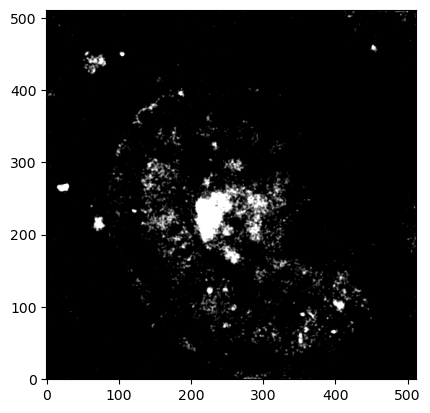

In [4]:
plt.imshow(c1_frames[0], cmap = 'gray', origin = 'lower')

In [5]:
# Example using Otsu's thresholding for segmentation
segmented_frames = []
for frame in c1_frames:
    scaled_frame = skimage.exposure.rescale_intensity(frame, out_range = (0, 255))
    smoothed_frame = skf.gaussian(scaled_frame, sigma=4)
    thresh = skf.threshold_otsu(smoothed_frame, )
    segmented_frame = smoothed_frame > thresh  # Adjust this condition based on your needs
    segmented_frames.append(segmented_frame)

segmented_frames = np.array(segmented_frames)

# Import and prepare data

## ROIs

In [6]:
path = '/mnt/g/My Drive/MKA/Papers/Sandra/Sandra annotations/2022_02/Image_analysis'

image_shape = (512, 512) #Set image size (pixels) 

timepoints = 30

In [7]:
#Single ROI file
##Add a "pseudoframe" to make following code consistent
rois = read_roi.read_roi_zip(os.path.join(path, 'RoiSet all frames.zip'))
rois = {i: rois for i in range(1, timepoints+1)}

In [8]:
roi_patches = {}
coords_dict = {}
for frame in rois.keys():
    roi_patches[frame] = {}
    coords_dict[frame] = {name: {'polygon_coords': [], 'centroid': ()} for name in rois[frame].keys()}
    for name in rois[frame].keys():
        x, y = rois[frame][name]['x'], rois[frame][name]['y']
        y = image_shape[1]-np.array(y)
        coords_dict[frame][name]['polygon_coords'] = list(zip(x, y))
        coords_dict[frame][name]['centroid'] = (sum(x)/len(x), sum(y)/len(y)) #calculate centroid for the polygon
        
        #Create matplotlib patches (polygons) from the ROI coordinates with black border and no fill.
        polygon = mpl.patches.Polygon(coords_dict[frame][name]['polygon_coords'], ec = 'k', closed = True, fill = False, alpha = 0.5)
        roi_patches[frame][name] = polygon

In [9]:
#Check if any frame has duplicate ROIs
df = pd.DataFrame([(frame, len(rois[frame].keys())) for frame in rois.keys()], columns = ['Frame', 'ROIs']).set_index('Frame')
if len(df['ROIs'].value_counts())>1:
    print('The following frames have duplicated ROIs: {}'.format(df.index[df['ROIs'] == df['ROIs'].value_counts().idxmin()][0]))
    print(df)
else:
    print('No duplicates')

No duplicates


In [10]:
#Make a helper dictionary for centroids
centroid_dict = {frame: 
                 {name: coords_dict[frame][name]['centroid'] for name in coords_dict[frame].keys()}
                for frame in coords_dict.keys()}
centroid_dict[1] #Check values for frame number 1

{'0002-0148-0196': (195.05309734513276, 365.7920353982301),
 '0002-0164-0177': (177.99126637554585, 351.65502183406113),
 '0002-0165-0164': (162.84140969162996, 350.6299559471366),
 '0002-0184-0148': (144.67768595041323, 328.8595041322314),
 '0002-0210-0130': (125.17391304347827, 302.9217391304348),
 '0002-0291-0126': (125.41441441441441, 218.92342342342343),
 '0002-0306-0133': (130.57009345794393, 204.33177570093457),
 '0002-0317-0138': (136.70506912442397, 192.2073732718894),
 '0002-0331-0144': (141.84324324324325, 177.45405405405404),
 '0002-0155-0181': (183.02904564315352, 363.0),
 '0002-0200-0137': (138.61410788381744, 312.4771784232365),
 '0002-0169-0151': (152.7093023255814, 344.18992248062017)}

Assign cell numbers according to the order the cells come in (this is consistent throughout the imaging, regardles of crypt and cell movements).

In [11]:
#Sort ROIs based on their order (angle of their centroid) on a circle centered on the middle of the image
roi_names = {x: [] for x in np.arange(0,len(centroid_dict[1].keys()))}

for frame in sorted(centroid_dict.keys()):
    (X_names, X) = zip(*centroid_dict[frame].items())
    X = np.array(X)-np.array(image_shape)/2 #centroid coordinates relative to the middle of image
    X = [list(a) for a in X] #values need to be in a list for next steps
    Xs = sorted(X, key = lambda c: math.atan2(c[0], c[1])) #Sort centroids based on their angle to the X-axis
    for pos, x in enumerate(Xs): #For each sorted position, find which roi name corresponded to it
        ix = X.index(x)
        roi_names[pos].append('{}-{}'.format(frame, X_names[ix])) #Append ROI name to the correct position, add frame name to ROI name to make unique

Check that each cell is present in the entire timelapse (16 frames)

In [12]:
names = {n: ix for ix in roi_names.keys() for n in roi_names[ix]}
pd.DataFrame.from_dict(names, orient = 'index').value_counts().sort_index()

0     30
1     30
2     30
3     30
4     30
5     30
6     30
7     30
8     30
9     30
10    30
11    30
dtype: int64

Check that results look fine

ax = axes[ix // ncols, ix % ncols]


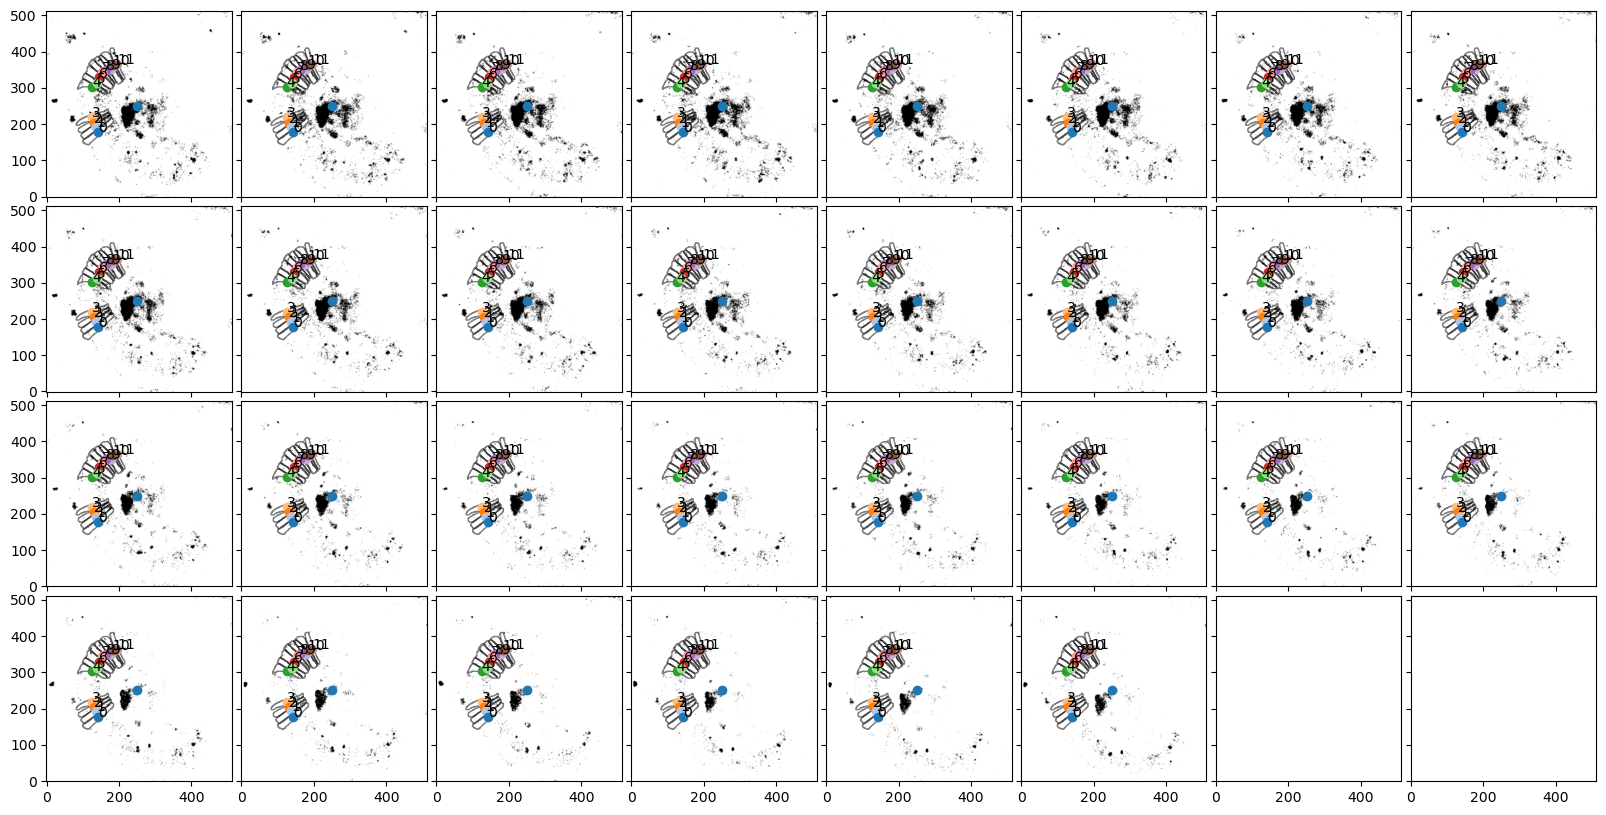

In [13]:
cmap = sbn.color_palette(palette = 'tab20', n_colors = len(roi_names.keys())) #Use 'tab20' as a color palette for assigning cell colors.
frames = list(roi_patches.keys())

ncols = 8

#Change the location of im_x and im_y because crypt lumen isn't directly in the image center
im_x, im_y = image_shape[0]/2, image_shape[1]/3
im_x, im_y = (250, 250)

fig, axes = initialize_subplots(len(frames), ncols = ncols, sharey = True, sharex = True, gridspec_kw = {'wspace':0.05, 'hspace':0.05}, figsize = (20, 10))

for ix, f in enumerate(frames):
    ax = get_ax(axes,ix, ncols)
    ax.imshow(c1_frames[ix], cmap = 'gray_r', origin = 'lower')
        
    #Plot ROIs
    roi_p = mpl.collections.PatchCollection(roi_patches[f].values(), match_original = True)
    ax.add_collection(roi_p)
    ax.autoscale()
    [ax.scatter(coords_dict[f][name]['centroid'][0], coords_dict[f][name]['centroid'][1], 
                color = cmap[names['{}-{}'.format(f, name)]] if '{}-{}'.format(f, name) in names.keys() else 'k') 
     for name in coords_dict[f].keys()]
    
    [ax.text(coords_dict[f][name]['centroid'][0], coords_dict[f][name]['centroid'][1], s = names['{}-{}'.format(f, name)])
     for name in coords_dict[f].keys()]
    
    ax.scatter(im_x, im_y)

## Find BM and Lumen points

In [14]:
c3_frames = np.flip(np.array(img)[:, 2, :, :], axis = 1)
c4_frames = np.flip(np.array(img)[:, 3, :, :], axis = 1)

In [15]:
lumen_df = get_annotation_coordinates(c3_frames)
lumen_df

ImageNumber ObjectNumber  Location_Center_X  Location_Center_Y
0             1            1              185.0             213.00
1             1            2              178.0             223.00
2             1            3              174.0             229.00
3             1            4              171.0             239.00
4             1            5              164.0             283.00
..          ...          ...                ...                ...
355          30            8              185.9             307.95
356          30            9              191.1             311.05
357          30           10              204.0             313.00
358          30           11              212.0             317.00
359          30           12              217.0             321.00

[360 rows x 4 columns]

In [16]:
bm_df = get_annotation_coordinates(c4_frames)
bm_df

ImageNumber ObjectNumber  Location_Center_X  Location_Center_Y
0             1            1              105.0              146.0
1             1            2               98.0              164.0
2             1            3               88.0              181.0
3             1            4               82.0              198.0
4             1            5               93.0              315.0
..          ...          ...                ...                ...
355          30            8              122.0              372.0
356          30            9              135.0              383.0
357          30           10              146.0              388.0
358          30           11              158.0              398.0
359          30           12              179.0              409.0

[360 rows x 4 columns]

### Check results

Plot ROIs, centroid, Lumen and BM dots

ax = axes[ix // ncols, ix % ncols]


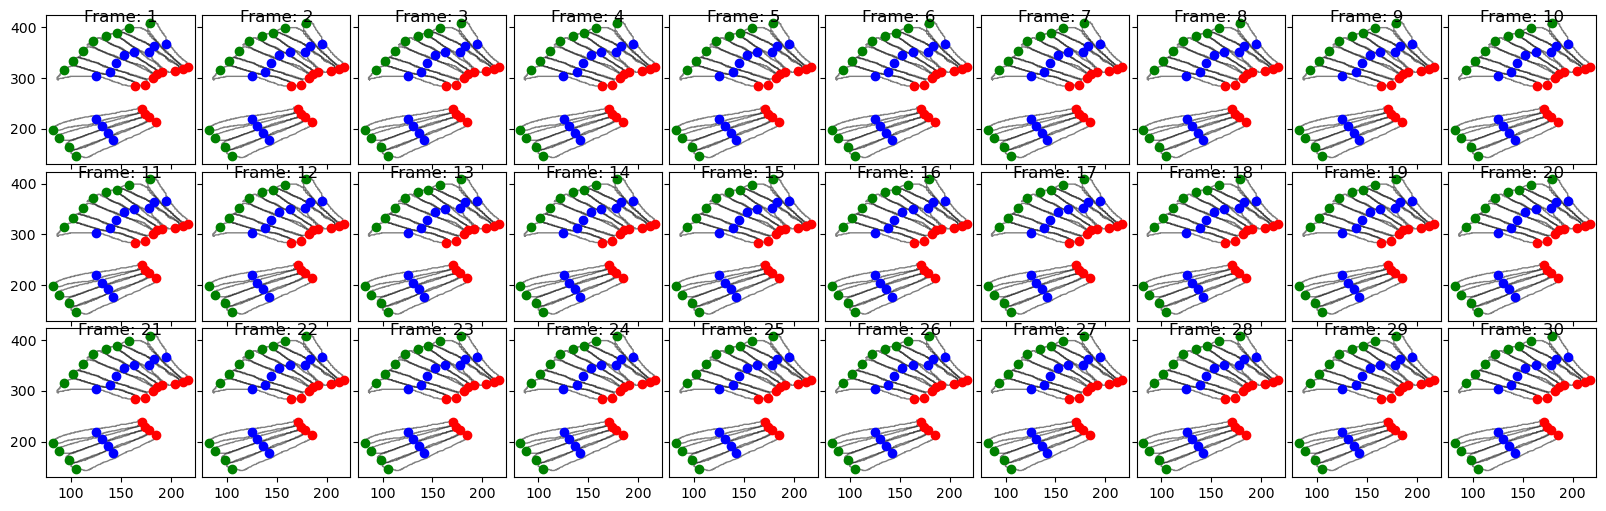

In [17]:
frames = roi_patches.keys()

ncols = 10
fig, axes = initialize_subplots(len(frames), ncols = ncols, sharey = True, sharex = True, gridspec_kw = {'wspace':0.05, 'hspace':0.05}, figsize = (20, 6))

for ix, f in enumerate(natsorted(frames)):
    ax = get_ax(axes,ix, ncols)
    roi_p = mpl.collections.PatchCollection(roi_patches[f].values(), match_original = True)
    ax.add_collection(roi_p)
    ax.autoscale()
    [ax.scatter(coords_dict[f][name]['centroid'][0], coords_dict[f][name]['centroid'][1], c = 'blue') for name in coords_dict[f].keys()]
    ax.set_title(f'Frame: {f}', y = 0.9)
    
    lum_x, lum_y = lumen_df.query('ImageNumber == @f')[['Location_Center_X', 'Location_Center_Y']].T.values
    bm_x, bm_y = bm_df.query('ImageNumber == @f')[['Location_Center_X', 'Location_Center_Y']].T.values
    
    ax.scatter(bm_x, bm_y, c = 'green')
    ax.scatter(lum_x,lum_y, c = 'red')

## Assign Lumen and BM dots to cells

Use the same strategy as for ROIs

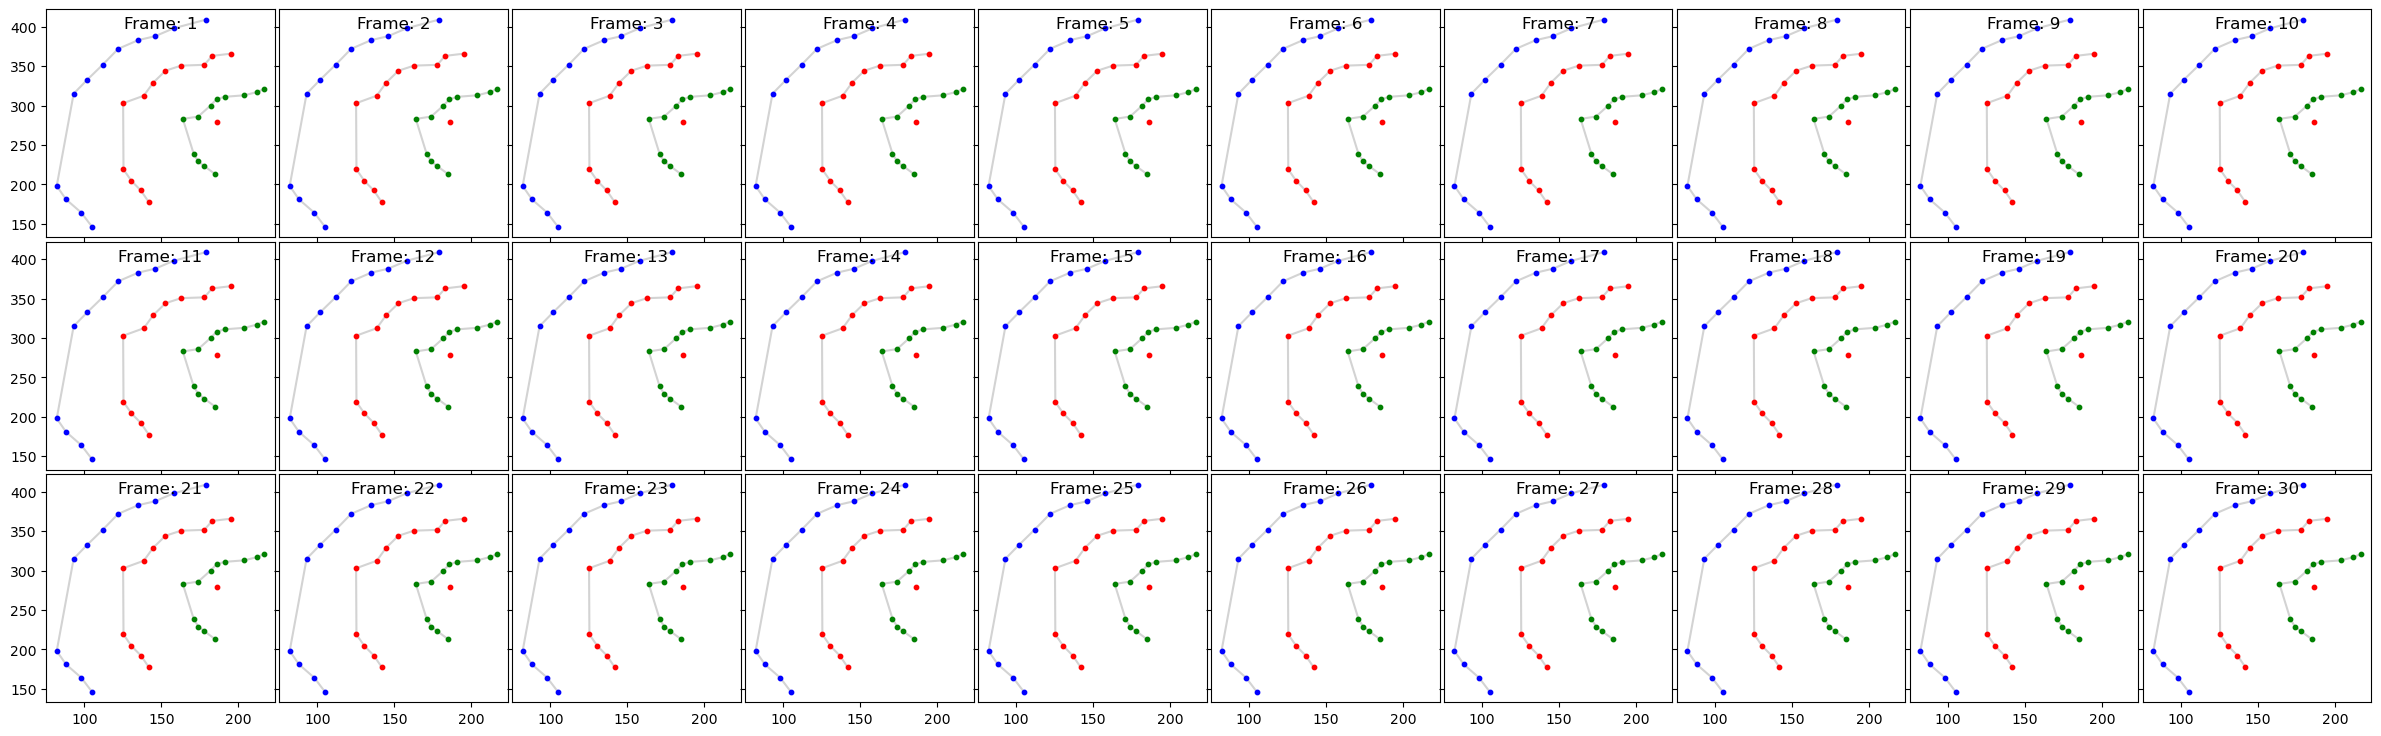

In [18]:
lumen_results, bm_results = [], []
roi_results = {}

ref_line = [300, 300] #define the crypt lumen orientation. point should lie outside of the central area, pointing towards the crypt opening
fig, axes = plt.subplots(ncols = 10, nrows = 3, figsize = (30, 3*3), sharex = True, sharey = True, gridspec_kw = {'wspace': 0.02, 'hspace': 0.02})

for frame in frames:
    # Extract coordinates for the current frame from the dataframes or roi coordinate dictionary
    lumen_coords = lumen_df.query('ImageNumber == @frame')[['Location_Center_X', 'Location_Center_Y']].values
    bm_coords = bm_df.query('ImageNumber == @frame')[['Location_Center_X', 'Location_Center_Y']].values
    roi_coords = np.array([coords_dict[frame][name]['centroid'] for name in coords_dict[frame]])
    
    # Call the modified plotting function for each set of coordinates
    center = np.mean(lumen_coords, axis=0)
    plot_polar_sorted([lumen_coords, bm_coords, roi_coords], center, ref_line = ref_line, ax = axes.flatten()[frame-1], colors = ['green', 'blue', 'red'], s = 10, frame = frame)

    # Group coordinates from lumen, basement membrane, and ROI based on their angular order
    grouped_coords, center = group_coordinates([lumen_coords, bm_coords, roi_coords], ref_line)
    
    #Find the index positions in the grouped coordinates and extend the result list
    lumen_results.extend(get_sorted_indeces(grouped_coords, lumen_coords, 0))
    bm_results.extend(get_sorted_indeces(grouped_coords, bm_coords, 1))

    # For ROI coordinates, find index positions in the grouped coordinates
    # Construct a dictionary for the current frame mapping ROI index to the corresponding name in coords_dict
    roi_results[frame] = {get_sorted_indeces(grouped_coords, roi_coords, 2)[ix]: name for ix, name in enumerate([*coords_dict[frame]])}

lumen_df['Ordered_Number'] = lumen_results
bm_df['Ordered_Number'] = bm_results

ax = axes[ix // ncols, ix % ncols]


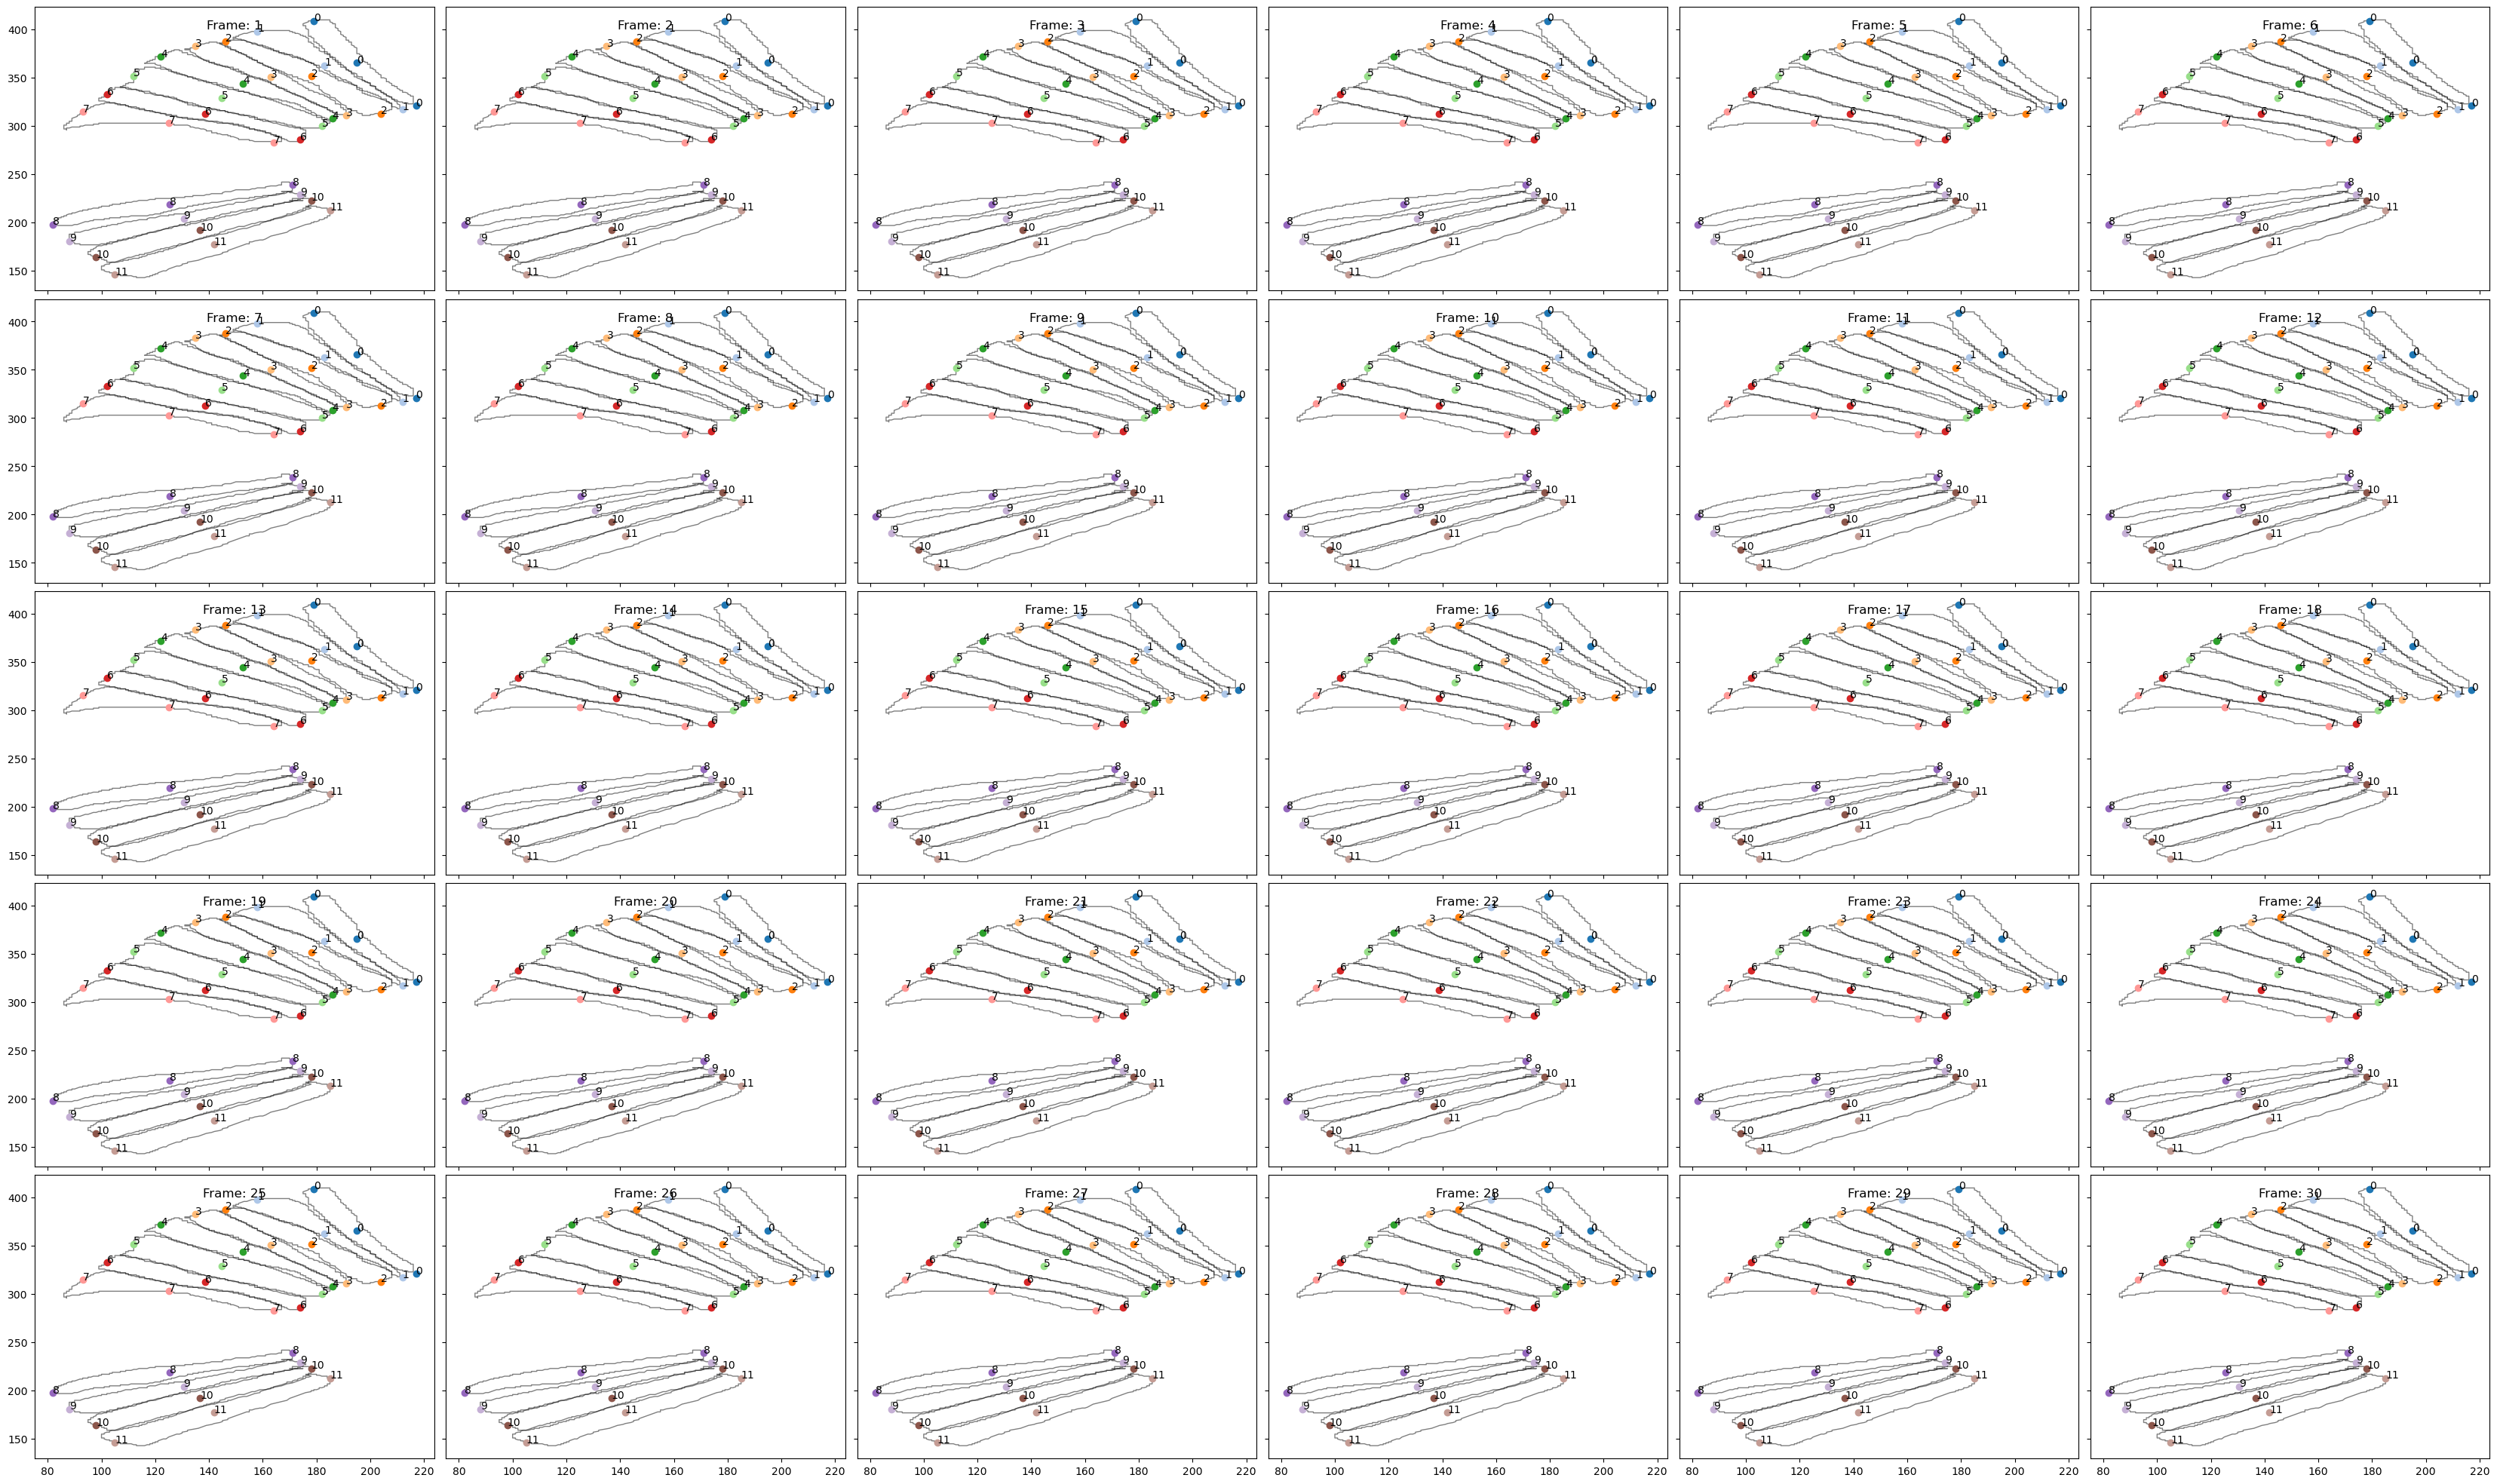

In [19]:
cmap = sbn.color_palette(palette = 'tab20', n_colors = len(roi_names))
frames = roi_patches.keys()
ncols = 6

fig, axes = initialize_subplots(len(frames), ncols = ncols, sharey = True, sharex = True, gridspec_kw = {'wspace':0.03, 'hspace':0.03})

for ix, frame in enumerate(frames):
    ax = get_ax(axes,ix, ncols)
    roi_p = mpl.collections.PatchCollection(roi_patches[frame].values(), match_original = True)
    ax.add_collection(roi_p)
    ax.autoscale()
    
    for group, name in roi_results[frame].items():
        x, y = coords_dict[frame][name]['centroid']
        ax.scatter(x, y, color = cmap[group]) 
        ax.text(x, y, s = str(group))
        for comp in ['lumen', 'BM']:
            df = {'lumen': lumen_df, 'BM': bm_df}[comp]
            x, y = df.query('ImageNumber == @frame & Ordered_Number == @group')[['Location_Center_X', 'Location_Center_Y']].values.flatten()
            ax.scatter(x, y, color = cmap[group])
            ax.text(x = x, y = y, s = str(group))
    
    ax.set_title(f'Frame: {frame}', y = 0.9)

## Make masks out of ROIs

In [21]:
for frame, f_dict in coords_dict.items():
    for name, coords in f_dict.items():
        mask_coords = np.transpose(polygon2mask(image_shape = image_shape, polygon = coords['polygon_coords'])) #Need to transpose because default output is (y, x) not (x, y)
        coords_dict[frame][name]['mask'] = mask_coords

ax = axes[ix // ncols, ix % ncols]


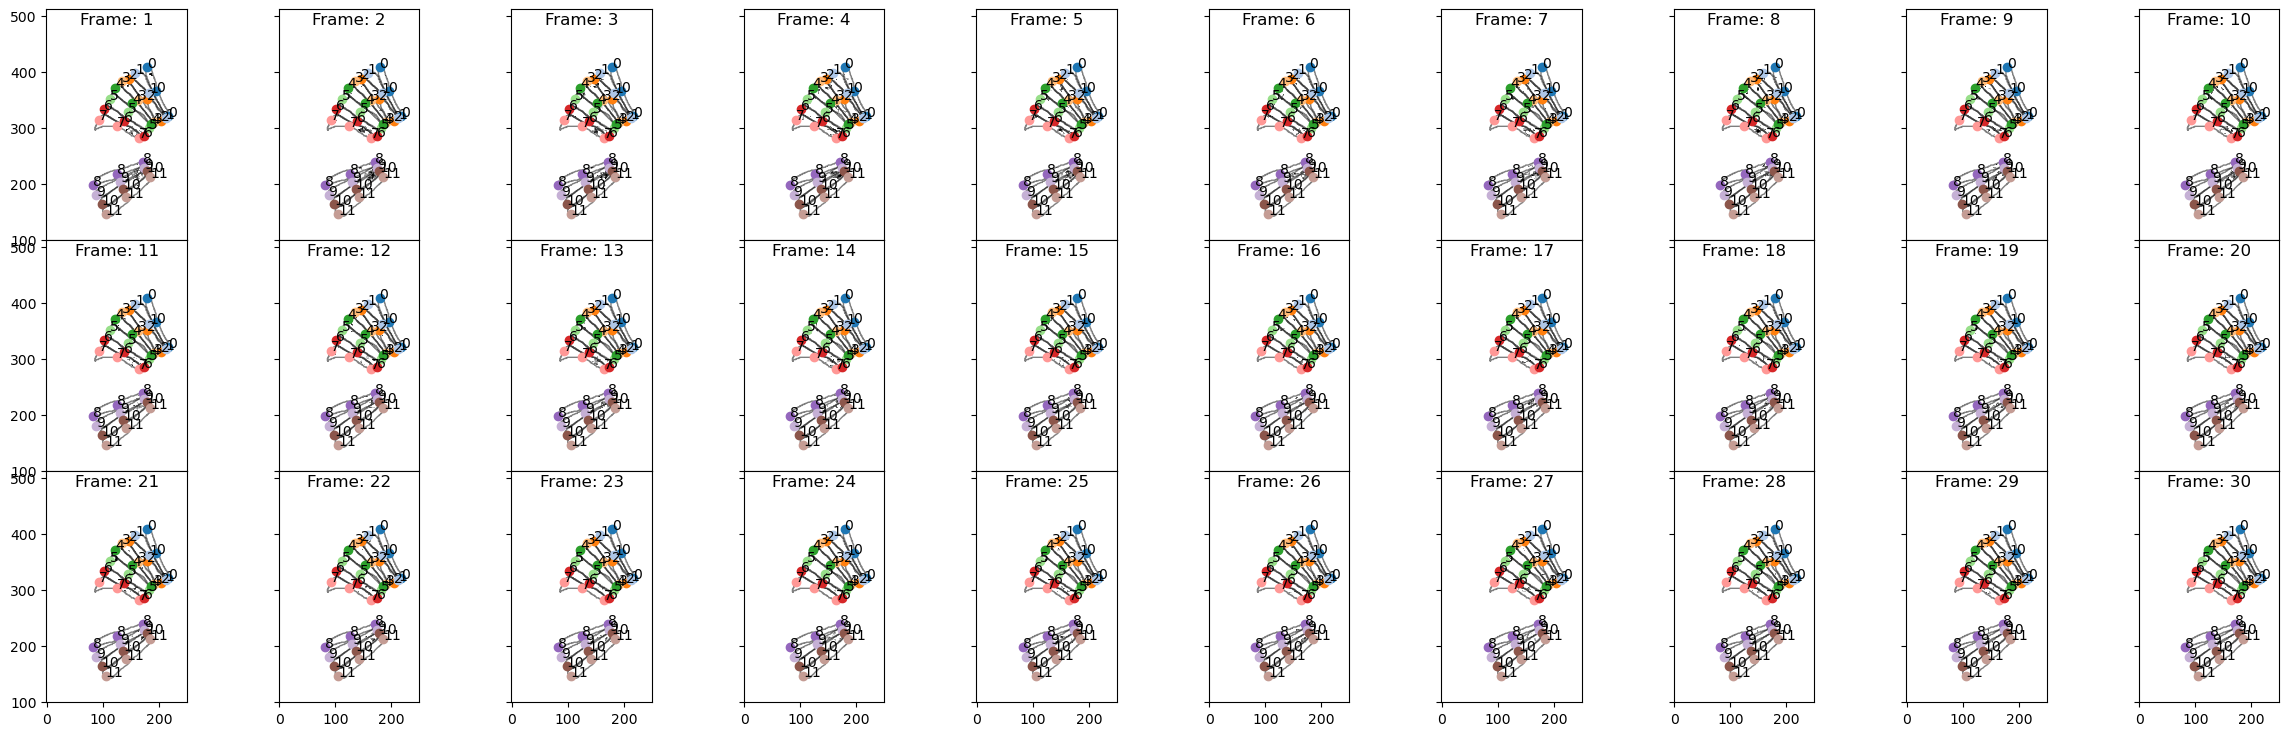

In [27]:
cmap = sbn.color_palette(palette = 'tab20', n_colors = len(roi_names))
frames = roi_patches.keys()
ncols = 10

fig, axes = initialize_subplots(len(frames), ncols = ncols, sharey = True, sharex = True, gridspec_kw = {'wspace':0.0, 'hspace':0.0}, figsize = (30, 9))

for ix, frame in enumerate(frames):
    ax = get_ax(axes,ix, ncols)
    
    roi_p = mpl.collections.PatchCollection(roi_patches[frame].values(), match_original = True)
    ax.add_collection(roi_p)
    
    for group, name in roi_results[frame].items():
        mask = c1_frames[frame-1] * coords_dict[frame][name]['mask']
        mask = np.where(mask == 0, np.nan, mask)
        ax.imshow(mask, origin = 'lower', cmap = 'gray_r', )
        x, y = coords_dict[frame][name]['centroid']
        ax.scatter(x, y, color = cmap[group]) 
        ax.text(x, y, s = str(group))
        for comp in ['lumen', 'BM']:
            df = {'lumen': lumen_df, 'BM': bm_df}[comp]
            x, y = df.query('ImageNumber == @frame & Ordered_Number == @group')[['Location_Center_X', 'Location_Center_Y']].values.flatten()
            ax.scatter(x, y, color = cmap[group])
            ax.text(x = x, y = y, s = str(group))
    
    ax.set_title(f'Frame: {frame}', y = 0.9)
    ax.set_xlim(right = 250)
    ax.set_ylim(bottom = 100)

# Rotate points and ROIS around the center-lumen axis

## Combine separate annotation dataframes and dictionaries into one dataframe

In [28]:
center_df = lumen_df[['ImageNumber', 'Ordered_Number']]
center_df['Lumen'] = [tuple(i) for i in lumen_df[['Location_Center_X', 'Location_Center_Y']].values]
center_df = center_df.set_index(['ImageNumber', 'Ordered_Number'])
center_df['BM'] = [tuple(i) for i in bm_df.set_index(['ImageNumber', 'Ordered_Number']).loc[center_df.index][['Location_Center_X', 'Location_Center_Y']].values]

# Add Roi_name, Roi_centroid, and Roi_coords columns
center_df['Roi_name'] = [roi_results[frame][group] for frame, group in center_df.index]

# Set index for roi_results and coords_dict lookup
lookup_index = center_df.reset_index().set_index(['ImageNumber', 'Roi_name']).index
center_df['Roi_centroid'] = [coords_dict[frame][name]['centroid'] for frame, name in lookup_index]
center_df['Roi_coords'] = [coords_dict[frame][name]['polygon_coords'] for frame, name in lookup_index]

# Vectorize angle calculation
center_df['Angle'] = np.arctan2(center_df['BM'].str[1] - center_df['Lumen'].str[1],
                                center_df['BM'].str[0] - center_df['Lumen'].str[0])
center_df['Center'] = [np.mean(np.stack(row), axis = 0) for row in center_df[['Lumen', 'BM']].values]

center_df['Patches'] = [mpl.patches.Polygon(roi, ec = 'k', closed = True, fill = False, alpha = 0.5) for roi in center_df['Roi_coords'].values]

# Sort DataFrame index
center_df.sort_index(inplace=True)
center_df

/tmp/ipykernel_32528/3263114270.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_df['Lumen'] = [tuple(i) for i in lumen_df[['Location_Center_X', 'Location_Center_Y']].values]


Lumen              BM        Roi_name  \
ImageNumber Ordered_Number                                                    
1           0                (217.0, 321.0)  (179.0, 409.0)  0002-0148-0196   
            1                (212.0, 317.0)  (158.0, 398.0)  0002-0155-0181   
            2                (204.0, 313.0)  (146.0, 388.0)  0002-0164-0177   
            3               (191.1, 311.05)  (135.0, 383.0)  0002-0165-0164   
            4               (185.9, 307.95)  (122.0, 372.0)  0002-0169-0151   
...                                     ...             ...             ...   
30          7                (164.0, 283.0)   (93.0, 315.0)  0002-0210-0130   
            8                (171.0, 239.0)   (82.0, 198.0)  0002-0291-0126   
            9                (174.0, 229.0)   (88.0, 181.0)  0002-0306-0133   
            10               (178.0, 223.0)   (98.0, 164.0)  0002-0317-0138   
            11               (185.0, 213.0)  (105.0, 146.0)  0002-0331-0144   

                                                        Roi_centroid  \
ImageNumber Ordered_Number                                             
1           0                (195.05309734513276, 365.7920353982301)   
            1                            (183.02904564315352, 363.0)   
            2               (177.99126637554585, 351.65502183406113)   
            3                (162.84140969162996, 350.6299559471366)   
            4                (152.7093023255814, 344.18992248062017)   
...                                                              ...   
30          7                (125.17391304347827, 302.9217391304348)   
            8               (125.41441441441441, 218.92342342342343)   
            9               (130.57009345794393, 204.33177570093457)   
            10               (136.70506912442397, 192.2073732718894)   
            11              (141.84324324324325, 177.45405405405404)   

                                                                   Roi_coords  \
ImageNumber Ordered_Number                                                      
1           0               [(176, 404), (176, 403), (176, 402), (176, 401...   
            1               [(150, 391), (151, 390), (152, 390), (152, 389...   
            2               [(145, 384), (146, 383), (146, 382), (147, 382...   
            3               [(133, 379), (133, 378), (133, 377), (134, 376...   
            4               [(116, 365), (117, 365), (118, 365), (119, 365...   
...                                                                       ...   
30          7               [(87, 298), (88, 298), (89, 299), (90, 299), (...   
            8               [(167, 239), (166, 239), (165, 238), (164, 238...   
            9               [(171, 232), (169, 232), (168, 232), (168, 231...   
            10              [(175, 223), (174, 223), (173, 223), (172, 223...   
            11              [(178, 215), (177, 214), (176, 214), (176, 213...   

                               Angle             Center  \
ImageNumber Ordered_Number                                
1           0               1.978428     [198.0, 365.0]   
            1               2.158799     [185.0, 357.5]   
            2               2.229064     [175.0, 350.5]   
            3               2.233041  [163.05, 347.025]   
            4               2.355022  [153.95, 339.975]   
...                              ...                ...   
30          7               2.718153     [128.5, 299.0]   
            8              -2.709898     [126.5, 218.5]   
            9              -2.632522     [131.0, 205.0]   
            10             -2.506140     [138.0, 193.5]   
            11             -2.444400     [145.0, 179.5]   

                                               Patches  
ImageNumber Ordered_Number                              
1           0               Polygon227((176, 404) ...)  
            1               Polygon242((150, 391) ...)  
            2          

### Add internal roi coordinates and their associated intensity values to the center_df dataframe

In [29]:
coordinates_in_roi = []
intensities = []
for (frame, n), name in center_df['Roi_name'].items():
    mask = np.transpose(coords_dict[frame][name]['mask'])
    coordinates_in_roi.append(np.array(list(zip(*np.where(mask)))))
    intensities.append(np.transpose(c1_frames[frame-1])[mask])

center_df['coordinates_in_roi'] = coordinates_in_roi
center_df['intensities'] = intensities
center_df

Lumen              BM        Roi_name  \
ImageNumber Ordered_Number                                                    
1           0                (217.0, 321.0)  (179.0, 409.0)  0002-0148-0196   
            1                (212.0, 317.0)  (158.0, 398.0)  0002-0155-0181   
            2                (204.0, 313.0)  (146.0, 388.0)  0002-0164-0177   
            3               (191.1, 311.05)  (135.0, 383.0)  0002-0165-0164   
            4               (185.9, 307.95)  (122.0, 372.0)  0002-0169-0151   
...                                     ...             ...             ...   
30          7                (164.0, 283.0)   (93.0, 315.0)  0002-0210-0130   
            8                (171.0, 239.0)   (82.0, 198.0)  0002-0291-0126   
            9                (174.0, 229.0)   (88.0, 181.0)  0002-0306-0133   
            10               (178.0, 223.0)   (98.0, 164.0)  0002-0317-0138   
            11               (185.0, 213.0)  (105.0, 146.0)  0002-0331-0144   

                                                        Roi_centroid  \
ImageNumber Ordered_Number                                             
1           0                (195.05309734513276, 365.7920353982301)   
            1                            (183.02904564315352, 363.0)   
            2               (177.99126637554585, 351.65502183406113)   
            3                (162.84140969162996, 350.6299559471366)   
            4                (152.7093023255814, 344.18992248062017)   
...                                                              ...   
30          7                (125.17391304347827, 302.9217391304348)   
            8               (125.41441441441441, 218.92342342342343)   
            9               (130.57009345794393, 204.33177570093457)   
            10               (136.70506912442397, 192.2073732718894)   
            11              (141.84324324324325, 177.45405405405404)   

                                                                   Roi_coords  \
ImageNumber Ordered_Number                                                      
1           0               [(176, 404), (176, 403), (176, 402), (176, 401...   
            1               [(150, 391), (151, 390), (152, 390), (152, 389...   
            2               [(145, 384), (146, 383), (146, 382), (147, 382...   
            3               [(133, 379), (133, 378), (133, 377), (134, 376...   
            4               [(116, 365), (117, 365), (118, 365), (119, 365...   
...                                                                       ...   
30          7               [(87, 298), (88, 298), (89, 299), (90, 299), (...   
            8               [(167, 239), (166, 239), (165, 238), (164, 238...   
            9               [(171, 232), (169, 232), (168, 232), (168, 231...   
            10              [(175, 223), (174, 223), (173, 223), (172, 223...   
            11              [(178, 215), (177, 214), (176, 214), (176, 213...   

                               Angle             Center  \
ImageNumber Ordered_Number                                
1           0               1.978428     [198.0, 365.0]   
            1               2.158799     [185.0, 357.5]   
            2               2.229064     [175.0, 350.5]   
            3               2.233041  [163.05, 347.025]   
            4               2.355022  [153.95, 339.975]   
...                              ...                ...   
30          7               2.718153     [128.5, 299.0]   
            8              -2.709898     [126.5, 218.5]   
            9              -2.632522     [131.0, 205.0]   
            10             -2.506140     [138.0, 193.5]   
            11             -2.444400     [145.0, 179.5]   

                                               Patches  \
ImageNumber Ordered_Number                               
1           0               Polygon227((176, 404) ...)   
            1               Polygon242((150, 391) ...)   
            2      

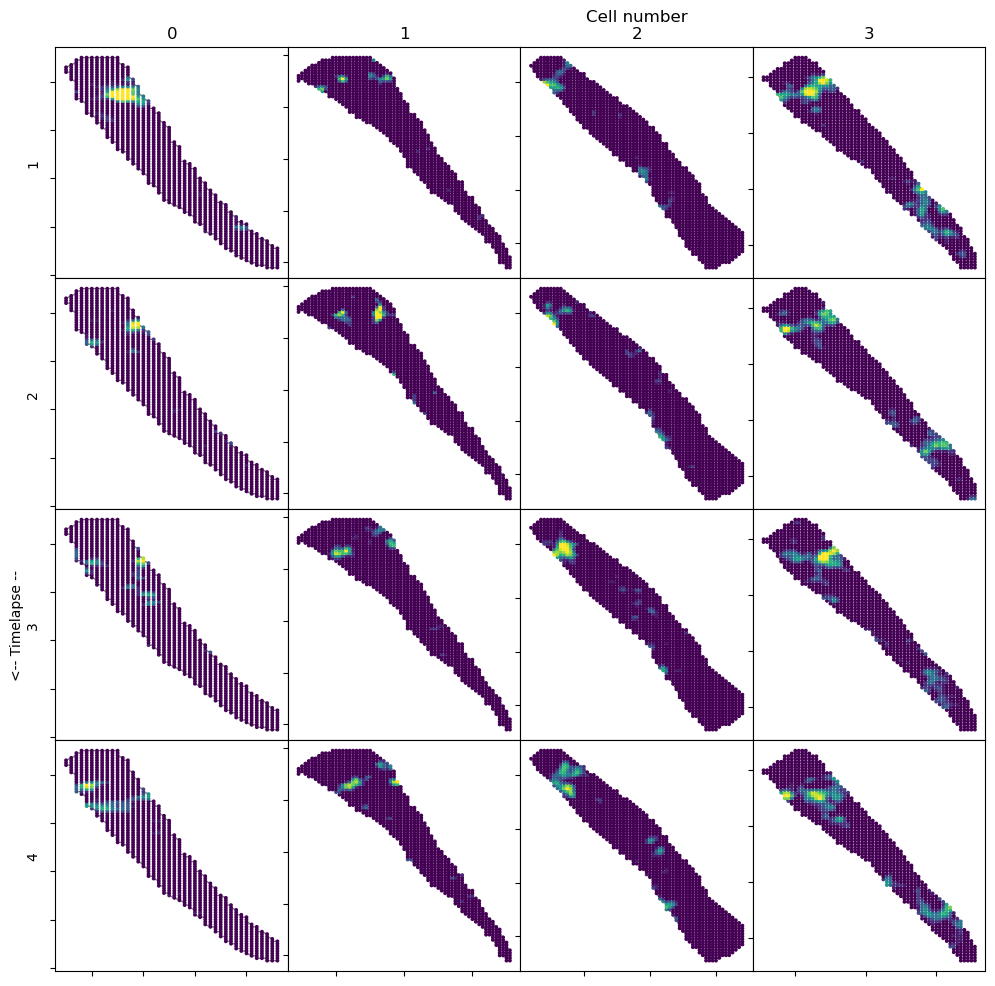

In [30]:
# Extracting unique groups and timepoints
groups = center_df.reset_index()['Ordered_Number'].unique()[:4]
timepoints = center_df.reset_index()['ImageNumber'].unique()[:4]

# Setting up the figure
ncols, nrows = len(groups), len(timepoints)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(3*ncols, 3*nrows), 
                         sharex=False, sharey=False, gridspec_kw={'wspace': 0.0, 'hspace': 0.0})

# Loop for plotting
for group_index, group in enumerate(groups):
    for time in timepoints:
        ax = axes[time-1, group_index]
        patch = center_df.loc[(time, group), 'Patches']
        patch.axes, patch.figure = None, None
        patch.set_transform(ax.transData)
        ax.add_patch(patch)

        # Setting titles and labels
        if time == 1:
            ax.set_title('Cell number\n{}'.format(group) if group == int(len(groups)//2) else group)
        if group == 0:
            ax.set_ylabel('<-- Timelapse --\n{}'.format(time) if time == int(len(timepoints)//2)+1 else time)

        # Scatter plot
        x, y = zip(*center_df.loc[(time, group)]['coordinates_in_roi'])
        intensities = center_df.loc[(time, group)]['intensities']
        ax.scatter(x=x, y=y, c=intensities, s = 3)
        ax.set_yticklabels([])
        ax.set_xticklabels([])

## Rotate annotations

In [31]:
#To make cells vertical, use "rad = math.pi/2 - angle" - this otherwise the cells become horizontal
#To make cells vertical with BM in the bottom use "rad = math.pi*1.5 - ang" for the calculation
orientation = 'BM_bottom'
rad = (math.pi*1.5) if orientation == 'BM_bottom' else (math.pi/2)
res = {}
for row in center_df.iterrows():
    frame, group = row[0]
    res[(frame, group)] = {f'rotated_{col}': [rotate(origin = row[1].loc['Lumen'], point = point, rad = rad - row[1].loc['Angle'])
                                              for point in row[1].loc[col]]
                           for col in ['Roi_coords', 'coordinates_in_roi']}      

In [32]:
# Apply rotation to 'BM' and 'Roi_centroid'
center_df_rotated = center_df.copy()

center_df_rotated['Center'] = center_df.apply(apply_rotation, column_name='Center', rad = rad, adjustment_rad=0, axis=1)
center_df_rotated['BM'] = center_df.apply(apply_rotation, column_name='BM', rad = rad, adjustment_rad=0, axis=1)
center_df_rotated['Roi_centroid'] = center_df.apply(apply_rotation, column_name='Roi_centroid', rad = rad, adjustment_rad=0, axis=1)

# Rotate 'Roi_coords'
#center_df_rotated['Roi_coords'] = center_df.apply(lambda row: [rotate(row['Lumen'], point, math.pi / 2 - row['Angle']) for point in row['Roi_coords']], axis=1)
center_df_rotated['Roi_coords'] = [res[i]['rotated_Roi_coords'] for i in center_df_rotated.index]
center_df_rotated['coordinates_in_roi'] = [res[i]['rotated_coordinates_in_roi'] for i in center_df_rotated.index]

center_df_rotated

Lumen  \
ImageNumber Ordered_Number                    
1           0                (217.0, 321.0)   
            1                (212.0, 317.0)   
            2                (204.0, 313.0)   
            3               (191.1, 311.05)   
            4               (185.9, 307.95)   
...                                     ...   
30          7                (164.0, 283.0)   
            8                (171.0, 239.0)   
            9                (174.0, 229.0)   
            10               (178.0, 223.0)   
            11               (185.0, 213.0)   

                                                                  BM  \
ImageNumber Ordered_Number                                             
1           0                (216.99999999999997, 225.1459442694259)   
            1                            (212.0, 219.65011556247228)   
            2               (203.99999999999994, 218.18966301082986)   
            3                             (191.1, 219.8139736726769)   
            4                (185.89999999999998, 217.4756251748596)   
...                                                              ...   
30          7                            (164.0, 205.12189011024986)   
            8                (170.99999999999997, 141.0102046129292)   
            9               (173.99999999999994, 130.51142198203894)   
            10              (177.99999999999991, 123.59678073623571)   
            11                           (185.0, 108.64962865423047)   

                                  Roi_name  \
ImageNumber Ordered_Number                   
1           0               0002-0148-0196   
            1               0002-0155-0181   
            2               0002-0164-0177   
            3               0002-0165-0164   
            4               0002-0169-0151   
...                                    ...   
30          7               0002-0210-0130   
            8               0002-0291-0126   
            9               0002-0306-0133   
            10              0002-0317-0138   
            11              0002-0331-0144   

                                                        Roi_centroid  \
ImageNumber Ordered_Number                                             
1           0               (219.39144902892673, 271.17757590401123)   
            1                 (210.5890820735018, 262.6554923938843)   
            2               (200.92716792500417, 266.51104818584923)   
            3               (189.04785060809834, 262.46080859011033)   
            4               (183.80142942869657, 258.85264370586464)   
...                                                              ...   
30          7                (161.7913088042881, 239.41717767814401)   
            8               (170.16120149685975, 189.19627566851028)   
            9               (174.37397002213004, 179.05464767625244)   
            10               (178.2717137009234, 171.48899779173303)   
            11               (184.54166883730056, 157.0910574281781)   

                                                                   Roi_coords  \
ImageNumber Ordered_Number                                                      
1           0               [(221.73636714210713, 228.54694798820776), (22...   
            1               [(222.53930372827935, 221.03686605303537), (22...   
            2               [(207.2380435483007, 220.74212730623304), (207...   
            3               [(195.1367825608567, 221.73865197212416), (195...   
            4               [(195.09155287458168, 218.1935080021853), (194...   
...                                                                       ...   
30          7               [(181.96396961842711, 206.63707839829448), (18...   
            8               [(169.32635633790048, 235.3669686359303), (168...   
            9               [(169.91830841616286, 227.84250537174768), (16...   
            10              [(176.21937356444832, 220.58559127

### Check results

ax = axes[ix // ncols, ix % ncols]


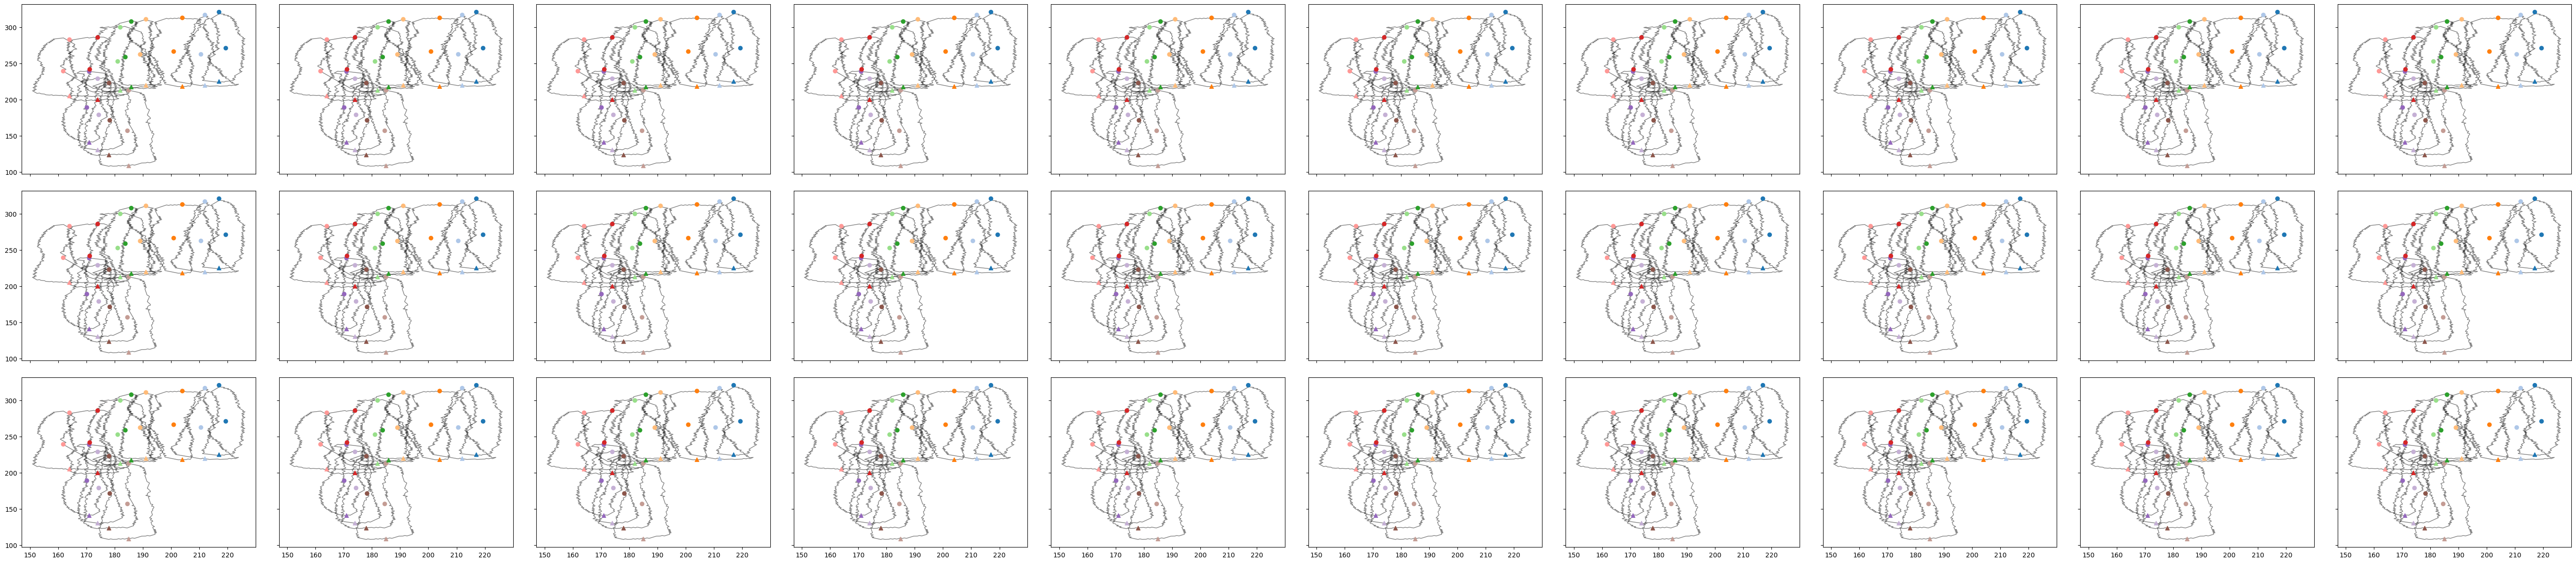

In [33]:
cmap = sbn.color_palette(palette = 'tab20', n_colors = len(roi_names.keys()))
frames = center_df.reset_index()['ImageNumber'].unique()

ncols = 10
fig, axes = initialize_subplots(len(frames), ncols = ncols, sharey = True, sharex = True, gridspec_kw = {'wspace':0.1, 'hspace':0.1})

for ix, frame in enumerate(frames):
    ax = get_ax(axes, ix, ncols)
    
    patches = []
    for c in center_df_rotated.loc[frame].index:
        polygon = mpl.patches.Polygon(center_df_rotated.loc[(frame, c), 'Roi_coords'], ec = 'k', closed = True, fill = False, alpha = 0.5)
        patches.append(polygon)
    roi_p = mpl.collections.PatchCollection(patches, match_original = True)
    ax.add_collection(roi_p)
    ax.autoscale()
    
    x, y = zip(*center_df_rotated.loc[frame]['Lumen'].values)
    ax.scatter(x, y, c = cmap)
    x, y = zip(*center_df_rotated.loc[frame]['BM'].values)
    ax.scatter(x, y, c = cmap, marker = '^') #Use a triangular marker for BM
    x, y = zip(*center_df_rotated.loc[frame]['Roi_centroid'].values)
    ax.scatter(x, y, c = cmap)
    #x, y = zip(*center_df.loc[frame]['Center'].values)
    #ax.scatter(x, y, c = cmap, s = 100) #Make the BM-Lumen center point bigger to check it's closenss to the ROI centroid

# Normalize all cells to have (0,0)-center

In [34]:
center_norm = center_df_rotated.copy()
for col in ['Lumen', 'BM', 'Roi_centroid', 'Center']:
    center_norm[col] = [tuple(x) for x in (np.array([x for x in center_df_rotated[col].values]) - np.array([x for x in center_df_rotated['Roi_centroid']]))]

center_norm['Roi_coords'] = [[r-np.array(c) for r in roi] for roi,c in center_df_rotated[['Roi_coords', 'Roi_centroid']].values]
center_norm['coordinates_in_roi'] = [[r-np.array(c) for r in roi] for roi,c in center_df_rotated[['coordinates_in_roi', 'Roi_centroid']].values]

#Smooth roi coordinates
#Change "skip_points" parameter to control the extent of smoothing
center_norm['Roi_coords_smooth'] = [list(zip(*smooth_polygon(list(zip(*roi))[0], list(zip(*roi))[1], skip_points = 5))) for roi in center_norm['Roi_coords'].values]

#Calculate new patches for the normalized ROIs
center_norm['Patches'] = [mpl.patches.Polygon(roi, ec = 'k', closed = True, fill = False, alpha = 0.5) for roi in center_norm['Roi_coords'].values]
center_norm['Patches_smooth'] = [mpl.patches.Polygon(roi, ec = 'k', closed = True, fill = False, alpha = 0.5) for roi in center_norm['Roi_coords_smooth'].values]

# Find a bisecting line through the middle of the ROI

In [35]:
# Apply the function to each row
processed_data = center_norm.apply(find_bisecting_lines_and_distances, axis=1)

# Update the original DataFrame
center_norm['bisecting_line'] = processed_data['bisecting_line']
center_norm['distance_to_border'] = processed_data['distance_to_border']

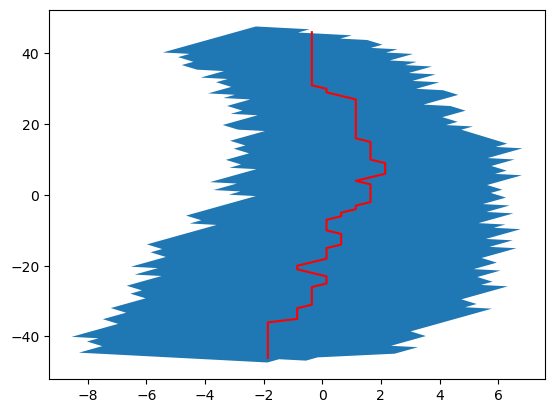

In [36]:
row = center_norm.loc[(1, 0)]
x, y = zip(*row['Roi_coords'])
bi_x, bi_y = zip(*row['bisecting_line'])
plt.fill(x, y)
plt.plot(bi_x, bi_y, color = 'red')

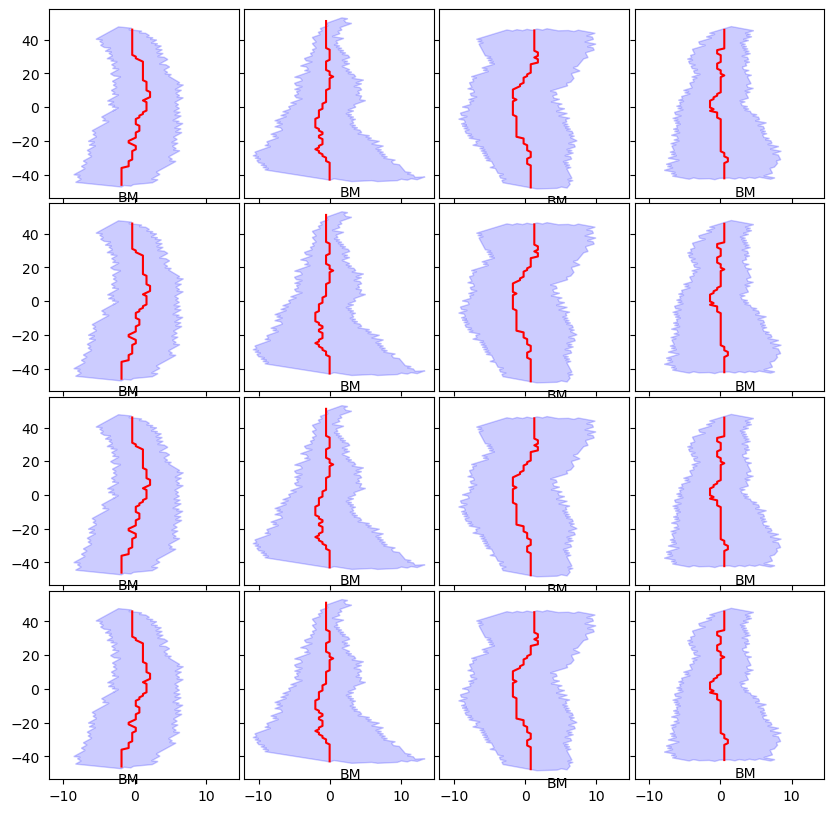

In [53]:
groups = center_df.reset_index()['Ordered_Number'].unique()[:4]
frames = center_df.reset_index()['ImageNumber'].unique()[:4]
fig, axes = plt.subplots(nrows = len(set(groups)), ncols = len(set(frames)), sharey = True, sharex = True, gridspec_kw = {'wspace': 0.03, 'hspace': 0.03}, figsize = (10, 10))

for ix, group in enumerate(groups):
    for frame in frames:
        ax = axes[frame-1, ix]
        x, y = zip(*center_norm.loc[(frame, group)]['Roi_coords'])
        ax.fill(x, y, alpha=0.2, color='blue')  # Original polygon
        bisecting_line = list(zip(*center_norm.loc[(frame, group)]['bisecting_line']))
        ax.plot(bisecting_line[0], bisecting_line[1], color = 'r')
        x, y = center_norm.loc[(frame, group)]['BM']
        ax.text(x = x, y = y-10, s = 'BM')

In [54]:
res_bisect_distances, res_roi_distances, res_sides = calculate_side_and_roi_distances(center_norm)
center_norm['side_of_cell'] = res_sides
center_norm['distance_to_bisect'] = res_bisect_distances
center_norm['distance_to_roi'] = res_roi_distances
center_norm['distance_fraction_bisect_to_roi'] = center_norm.apply(lambda row: calculate_distance_fraction(row['distance_to_bisect'], row['distance_to_roi']), axis=1)

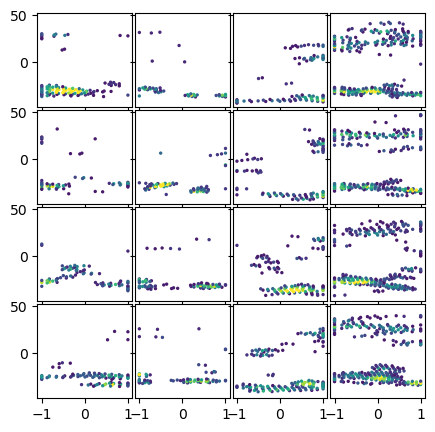

In [59]:
groups = center_df.reset_index()['Ordered_Number'].unique()[:4]
frames = center_df.reset_index()['ImageNumber'].unique()[:4]
fig, axes = plt.subplots(ncols = len(set(groups)), nrows = len(set(frames)), sharey = True, sharex = True, gridspec_kw = {'wspace': 0.03, 'hspace': 0.03}, figsize = (5, 5))
intensity_cutoff = 0
for (frame, group), row in center_norm.iterrows():
    if all([frame in frames, group in groups]):
        ax = axes[frame-1, group]
        i, y, f, side = row[['intensities','coordinates_in_roi', 'distance_fraction_bisect_to_roi', 'side_of_cell']]
        f = np.nan_to_num(f)
        
        _, y = zip(*y)
        f = np.nan_to_num(f) * side
        filter = i>intensity_cutoff
        #f = f[filter]
        
        #rank = np.argsort(i[filter])
        #ax.scatter(x = f[rank], y = np.array(y)[rank], c = i[rank], s = 2, vmin = 0)
        ax.scatter(x = f[filter], y = np.array(y)[filter], c = i[filter], s = 2, vmin = 0)

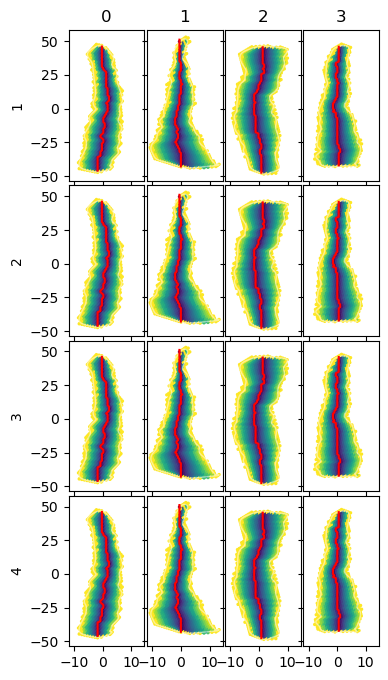

In [62]:
groups = center_norm.reset_index()['Ordered_Number'].unique()[:4]
frames = center_norm.reset_index()['ImageNumber'].unique()[:4]
frames = set(frames)
ncols = len(set(groups))
nrows = len(set(frames))
fig, axes = plt.subplots(ncols = ncols, nrows = nrows, sharey = True, sharex = True, gridspec_kw = {'wspace': 0.03, 'hspace': 0.03}, figsize = (1*ncols, 2*nrows))

for ix, (frame, group) in enumerate(center_norm.index):
    if all([frame in frames, group in groups]):
        i, f, side, coords, roi_coords, bisecting_line, distance_to_bisect, distance_to_roi = center_norm.loc[(frame,group)][['intensities', 'distance_fraction_bisect_to_roi', 'side_of_cell', 'coordinates_in_roi', 'Roi_coords_smooth', 'bisecting_line','distance_to_bisect', 'distance_to_roi']]
        ax = axes[frame-1, group]
        x, y = zip(*coords)
        ax.scatter(x, y, c = f, s = 2)
        
        polygon = mpl.patches.Polygon(roi_coords, ec = 'w', closed = True, fill = False, alpha = 0.5)
        ax.add_patch(polygon)
        
        bisect_x, bisect_y = zip(*bisecting_line)
        ax.plot(bisect_x, bisect_y, c = 'r')
        if group == 0:
            ax.set_ylabel(frame)
        if frame == 1:
            ax.set_title(group)

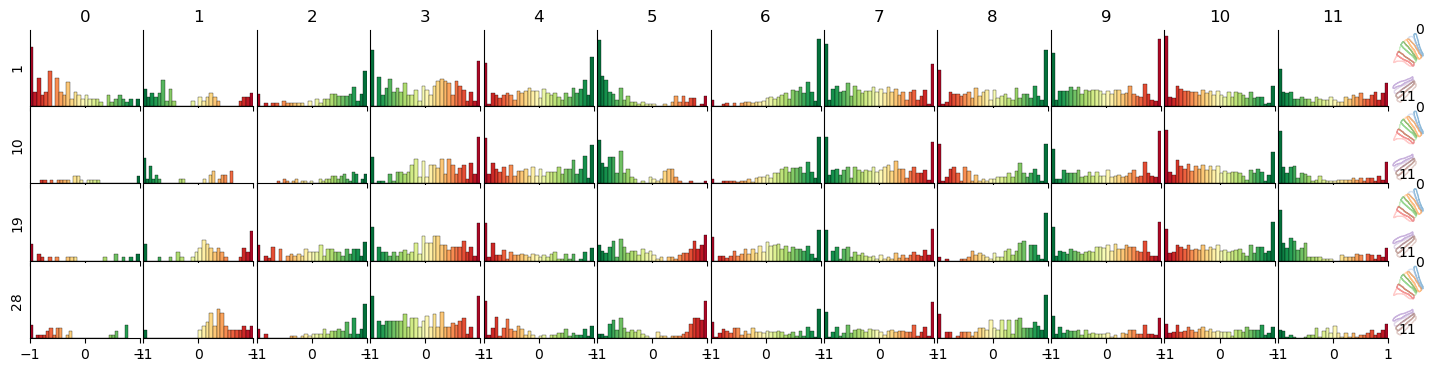

In [77]:
# Extract unique frames and groups from 'center_norm' index.
frames, groups = zip(*center_norm.index)
frames = list(set(frames))[::9]

# Create a figure with subplots for each combination of frame and group.
fig, axes = plt.subplots(ncols = len(set(groups))+1, nrows = len(set(frames)), sharey = False, sharex = False, gridspec_kw = {'wspace': 0.03, 'hspace': 0.03, 'width_ratios': [1]*len(set(groups))+[0.3]}, figsize = (18, 4))

# Constants for analysis.
n_bins = 30
intensity_cutoff = 1

max_values = find_max_intensity_per_group(center_norm, 'Ordered_Number', n_bins = n_bins)
plot_histograms_per_time_and_group(center_norm.loc[frames], axes, intensity_cutoff = intensity_cutoff, n_bins = n_bins, max_values = max_values)
plot_rois_on_right_side_axis(center_df.loc[frames], axes, group_col = 'Ordered_Number', cmap = 'tab20')

#fig.savefig(os.path.join(fig_path, 'Experiment_2022_fraction_count_histogram.pdf'), bbox_inches = 'tight')

In [78]:
center_norm['roi_shift'] = center_norm.reset_index().groupby('ImageNumber')['Roi_coords'].transform(find_shift_for_patches).values
center_norm['Roi_coords_shifted_side_by_side'] = center_norm.apply(lambda row: shift_x_coordinates_for_side_by_side(row), axis = 1)

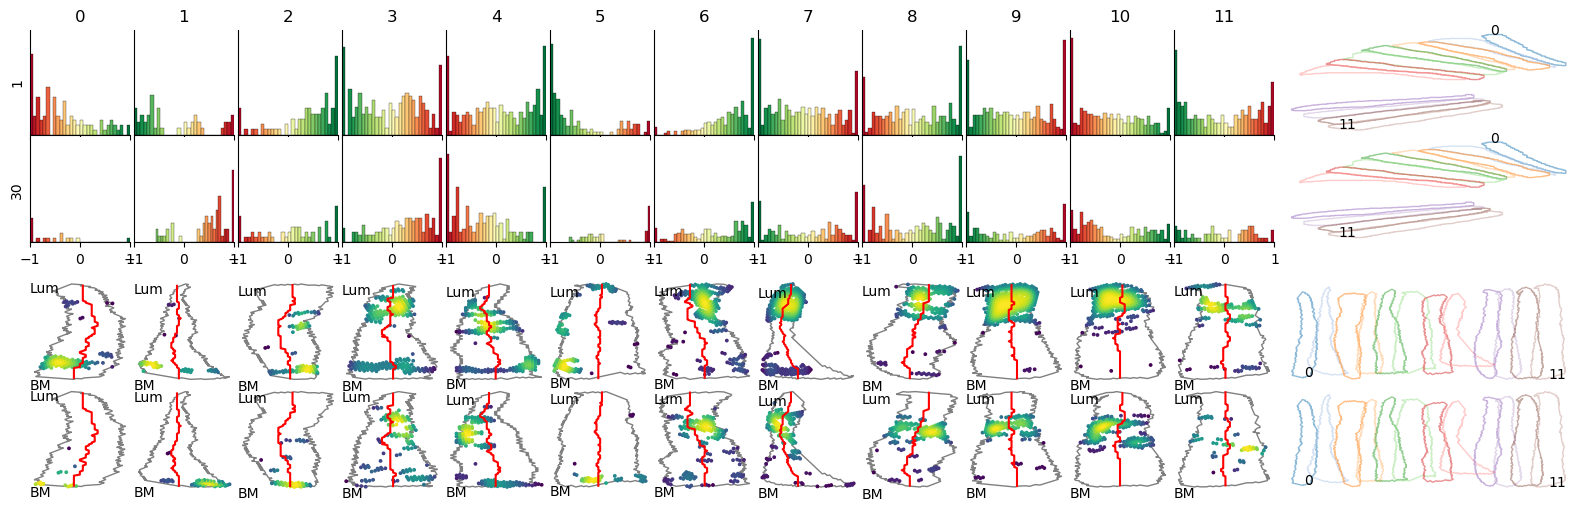

In [79]:
# Extract unique frames and groups from 'center_norm' index.
frames, groups = zip(*center_norm.index)
frames = [min(frames), max(frames)]

# Create a figure with subplots for each combination of frame and group.
fig, axes = plt.subplots(ncols = len(set(groups))+1, nrows = len(set(frames))+3, sharey = False, sharex = False, figsize = (20, 6),
                         gridspec_kw = {'wspace': 0.03, 'hspace': 0.03, 'width_ratios': [1]*len(set(groups))+[3], 'height_ratios': [1, 1, 0.3, 1, 1]})

# Constants for analysis.
n_bins = 30
intensity_cutoff = 1

max_values = find_max_intensity_per_group(center_norm.loc[frames], 'Ordered_Number', n_bins)
plot_histograms_per_time_and_group(center_norm.loc[frames], axes, intensity_cutoff = intensity_cutoff, n_bins = n_bins, max_values = max_values)
plot_rois_on_right_side_axis(center_df.loc[frames], axes, group_col = 'Ordered_Number', colorize = True, cmap = 'tab20')

df = center_norm.copy()
for (frame, group), row in df.loc[frames].iterrows():
    ax = axes[frames.index(frame) + 3, group]
    polygon = mpl.patches.Polygon(df.loc[(frame, group), 'Roi_coords'], ec = 'k', closed = True, fill = False, alpha = 0.5)
    ax.add_patch(polygon)

    x, y = zip(*df.loc[(frame, group)]['coordinates_in_roi'])
    intensities = np.array(df.loc[(frame, group)]['intensities'])
    x = np.array(x)[intensities > intensity_cutoff]
    y = np.array(y)[intensities > intensity_cutoff]
    c = calc_density(x, y)
    #ax.scatter(x=x, y=y, c=intensities[intensities > 1], s = 3, vmin = 0)
    ax.scatter(x=x, y=y, s = 3, vmin = 0, c = c)
    ax.set_ylabel(frame if group == 0 else '')
    
    x, y = zip(*df.loc[(frame, group)]['bisecting_line'])
    
    ax.plot(x, y, c = 'r')

    bm, lumen = df.loc[(frame, group)][['BM', 'Lumen']]
    ax.text(x = ax.get_xlim()[0], y = bm[1], s = 'BM', va = 'top')
    ax.text(x = ax.get_xlim()[0], y = lumen[1], s = 'Lum', va = 'top')
    ax.autoscale()
    ax.axis('off')
    
[ax.axis('off') for ax in axes[2, :]]

clear_output(wait = True)
for ix, frame in enumerate(set(frames)):
    ax = axes[ix+3, -1]
    df = center_norm.loc[frame].reset_index()
    groups = center_norm.reset_index()['Ordered_Number'].unique()
    for i, row in df.iterrows():
        x, y = row['BM']
        g, shift = row[['Ordered_Number', 'roi_shift']]
        patch = mpl.patches.Polygon(row['Roi_coords_shifted_side_by_side'], closed = True, fill = False, alpha = 0.5, ec = sbn.color_palette('tab20')[i])
        ax.add_patch(patch)
        ax.autoscale()
        if g in [min(groups), max(groups)]:
            ax.text(x = x+shift, y = y, s = g)

    # Customize the subplot appearance.
    ax.axis('off')

#fig.savefig(os.path.join(fig_path, 'Experiment_2022_fraction_count_histogram_first_last_frames_CELLS.pdf'), bbox_inches = 'tight')

# 7. Save dataset1

In [42]:
path = '/mnt/g/My Drive/MKA/Papers/Sandra/Sandra annotations/2022_02'
center_norm.to_pickle(os.path.join(path, 'Experiment807_analyzed_norm.pkl'))
center_norm.to_pickle(os.path.join(path, 'Experiment807_analyzed_raw.pkl'))
center_norm.to_pickle(os.path.join(path, 'Experiment807_analyzed_rotated.pkl'))